In [1]:
!pip install tflearn

    100% |████████████████████████████████| 102kB 2.3MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fb/06/72/0478c938ca315c6fddcce8233b80ec91a115ce4496a27e8c90
Successfully built tflearn


In [0]:
from __future__ import division, print_function, absolute_import

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

import tensorflow as tf

import pickle

In [3]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 1.2MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /content/.cache/pip/wheels/ea/bd/b1/14e948c56cce2c7ac1589346cb54d7efb659fa2ddfa6abba88
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1GdQbJGIEGgygikcCXpiWEOovkJm0o9Hz' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'train.pkl':
     PIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'validation.pkl':
     VALIDPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'test.pkl':
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: test.pkl, id: 19B2bZeyPXYqc0NVqUEG6frvtcO4Yqbiz
title: train.pkl, id: 1GLgcD2u-9TEzYVbdLuET1-kLl-g5pEjw
title: validation.pkl, id: 1DxGrSNgVBMoAFp5GWAY5Y26on_XyNAFe


In [0]:
X = []
Y = []
X_validate = []
Y_validate = []
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':'1',
    'bharadvajasana':'2',
    'pasasana':'3',
    'salamba_sarvangasana':'4',
    'salamba_sirsasana':'5',
    'virabhadrasana_I':'6',
    'virabhadrasana_II':'7',
    'virabhadrasana_III':'8'
}



In [0]:
num_class=len(label_pairs)

In [8]:
len(label_pairs)

8

In [0]:
dataFile = drive.CreateFile({'id': PIK}).GetContentFile('train.pkl')


In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')


In [0]:
validateFile = drive.CreateFile({'id': VALIDPIK}).GetContentFile('validation.pkl')


In [12]:
X_type = 'float64'
w = 64
h = 64
channels = 3

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            record[0]=np.resize(record[0],(w,h,channels))
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 6251


In [13]:
with open('validation.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            record[0]=np.resize(record[0],(w,h,channels))
            X_validate.append(record[0].astype(X_type))
            Y_validate.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Validation Data Size :" , len(X_validate))

processing done!
Validation Data Size : 1357


In [14]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            record[0]=np.resize(record[0],(w,h,channels))
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [0]:
#convert to categorical variables
Y = to_categorical(Y, 9)
Y_validate = to_categorical(Y_validate, 9)
Y_test = to_categorical(Y_test, 9)

In [16]:
tf.reset_default_graph()

from __future__ import division, print_function, absolute_import

import tflearn

# Residual blocks
# 32 layers: n=5, 56 layers: n=9, 110 layers: n=18
n = 5

# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
#img_prep.add_featurewise_zero_center(per_channel=True)

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
#img_aug.add_random_flip_leftright()
#img_aug.add_random_blur()
#img_aug.add_random_crop([64, 64], padding=4)

# Building Residual Network
network = tflearn.input_data(shape=[None, w, h, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
network = tflearn.conv_2d(network, 16, 3, regularizer='L2', weight_decay=0.0001)
network = tflearn.residual_block(network, n, 16)
network = tflearn.residual_block(network, 1 ,32, downsample=True)
network = tflearn.residual_block(network, n-1, 32)
network = tflearn.residual_block(network, 1, 64, downsample=True)
network = tflearn.residual_block(network, n-1, 64)
network = tflearn.batch_normalization(network)
network = tflearn.activation(network, 'relu')
network = tflearn.global_avg_pool(network)
# Regression
network = tflearn.fully_connected(network, 9, activation='softmax')
mom = tflearn.Momentum(0.1, lr_decay=0.1, decay_step=32000, staircase=True)
network = tflearn.regression(network, optimizer=mom,
                         loss='categorical_crossentropy')


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Training

start_time = time.time()

model = tflearn.DNN(network, checkpoint_path='.forever/model_resnet_cifar10',
                    max_checkpoints=10, tensorboard_verbose=0,
                    clip_gradients=0.)

In [18]:
model.fit(X, Y, n_epoch=50, validation_set=(X_validate, Y_validate),
          snapshot_epoch=20, snapshot_step=500,
          show_metric=True, batch_size=64, shuffle=True,
          run_id='resnet_cifar10')


Training Step: 4899  | total loss: 0.00679 | time: 35.682s
| Momentum | epoch: 050 | loss: 0.00679 - acc: 0.9991 -- iter: 6208/6251
Training Step: 4900  | total loss: 0.00645 | time: 37.789s
| Momentum | epoch: 050 | loss: 0.00645 - acc: 0.9992 | val_loss: 1.06358 - val_acc: 0.7996 -- iter: 6251/6251
--


In [0]:
import os
def authenticateWithGDrive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)
#Recursive function to walk through google drive repo        
def retrieveFolderfromGoogleDrive(parentfolder_id,targetdir='.') :
  drive=authenticateWithGDrive()
  file_list = drive.ListFile({'q': "'{parent_id}'".format(parent_id=parentfolder_id) + " in parents and trashed=false"}).GetList()
  for file1 in file_list:
    #print(file1['title'] +'__'+file1['mimeType'])
    sub_dir1=targetdir+'/'+file1['title']
    #if folder call same function
    if '.git' not in file1['title'] :
      if file1['mimeType'] == "application/vnd.google-apps.folder":
          if not os.path.isdir(sub_dir1):
            !mkdir {sub_dir1}
          retrieveFolderfromGoogleDrive(file1['id'],sub_dir1)
      else  :
        if not os.path.isfile(sub_dir1):
          drive.CreateFile({'id': file1['id']}).GetContentFile(sub_dir1)
dependencies_folder_id='19tYr3vwQsxc3l6HQLvfIgSK5gfr23soR'
retrieveFolderfromGoogleDrive(dependencies_folder_id)

In [20]:
model_name="resnet32_skeletal_insights_demo"
del tf.get_collection_ref(tf.GraphKeys.TRAIN_OPS)[:]
model.save(model_name)
print("Network trained and saved as tflearn-v0.63.tfl. time taken: " , time.time() - start_time)
!python tf_freeze.py --mfolder='.'
!ls



Network trained and saved as tflearn-v0.63.tfl. time taken:  2007.7981541156769
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Namespace(mfolder='.', ograph='frozen_model.pb') 

[INFO] input_checkpoint: /content/resnet32_skeletal_insights_demo
Converted 189 variables to const ops.
1676 ops in the final graph.
[INFO] output_graph: frozen_model.pb
[INFO] all done
checkpoint
datalab
frozen_model.pb
resnet32_skeletal_insights_demo.data-00000-of-00001
resnet32_skeletal_insights_demo.index
resnet32_skeletal_insights_demo.meta
test.pkl
tf_freeze.py
train.pkl
validation.pkl


In [21]:
test_images_and_labels = list(zip(X_test, Y_test))
#Predicting

correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0;

for (image, label) in (test_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    #print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        #correct_indices = np.append(correct_indices)
    else :
        wrong_count=wrong_count+1
        #wrong_indices = np.append(wrong_indices)
        #mistakes = list.append(mistakes,imagedata[0],label,pred])
        #plt.imshow(imagedata[0].astype('uint8'),aspect="auto")
        #plt.title("Pred: {pred} Actual:{label}".format(pred=pred, label=label))
        #plt.show()
        #input("Press Enter to continue...")

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)
print("Total Prediction Time :" + str(total_predict_time))

0.8264150943396227
219
46
Total Prediction Time :2.3323230743408203


In [0]:
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[27  0  0  0  0  0  0  1]
 [ 1 28  0  2  0  2  0  0]
 [ 0  2 23  0  0  0  0  1]
 [ 0  0  0 25  2  2  0  0]
 [ 1  0  0 16 25  0  0  1]
 [ 0  3  0  2  1 34  0  0]
 [ 0  2  0  1  1  3 31  0]
 [ 0  2  0  0  0  0  0 26]]
Confusion matrix, without normalization
[[27  0  0  0  0  0  0  1]
 [ 1 28  0  2  0  2  0  0]
 [ 0  2 23  0  0  0  0  1]
 [ 0  0  0 25  2  2  0  0]
 [ 1  0  0 16 25  0  0  1]
 [ 0  3  0  2  1 34  0  0]
 [ 0  2  0  1  1  3 31  0]
 [ 0  2  0  0  0  0  0 26]]
Normalized confusion matrix
[[0.96428571 0.         0.         0.         0.         0.
  0.         0.03571429]
 [0.03030303 0.84848485 0.         0.06060606 0.         0.06060606
  0.         0.        ]
 [0.         0.07692308 0.88461538 0.         0.         0.
  0.         0.03846154]
 [0.         0.         0.         0.86206897 0.06896552 0.06896552
  0.         0.        ]
 [0.02325581 0.         0.         0.37209302 0.58139535 0.
  0.         0.02325581]
 [0.         0.075      0.         0.05       0.025      

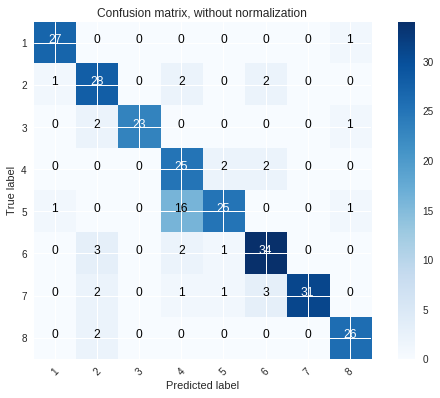

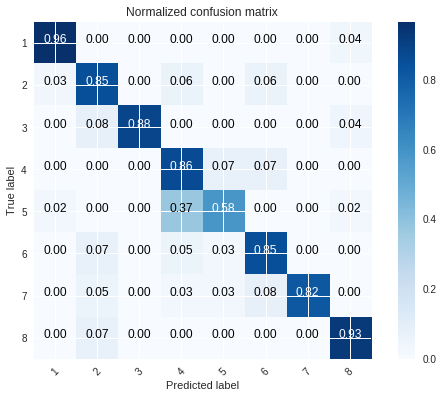

In [24]:
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
print(conf_mat)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [25]:
def createGoogleDrivefolder(name,parent_id):
  folder=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parent_id}],'mimeType': 'application/vnd.google-apps.folder'})
  folder.Upload()
  return folder.get('id')

def uploadFileToGoogleDrive(local_file_dir,name,parentfolder_id):
  file=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parentfolder_id}]})
  file.SetContentFile(local_file_dir)
  file.Upload()
  return file.get('id')

#Google Drive Id for project/models folder
model_parentfolder_id="1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe"

#Name of model folder
source_model_name = "resnet32_skeletal_insights"
target_model_name = 'resnet32_skeletal_insights'
model_folder_id=createGoogleDrivefolder(target_model_name,model_parentfolder_id)

#Create Files with Model Name in Google Drive
for filename in os.listdir('.'):
  if model_name in filename:
    print('upload model file with id:'+ filename)
    createGoogleDrivefolder=uploadFileToGoogleDrive('.'+'/'+filename,filename,model_folder_id)

upload model file with id:resnet32_skeletal_insights_demo.data-00000-of-00001
upload model file with id:resnet32_skeletal_insights_demo.index
upload model file with id:resnet32_skeletal_insights_demo.meta


In [0]:
import os, argparse

# The original freeze_graph function
# from tensorflow.python.tools.freeze_graph import freeze_graph 

# dir = os.path.dirname(os.path.realpath(__file__))

def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)
        
        # get graph definition
        gd = sess.graph.as_graph_def()

        # fix batch norm nodes
        for node in gd.node:
          if node.op == 'RefSwitch':
            node.op = 'Switch'
            for index in range(len(node.input)):
              if 'moving_' in node.input[index]:
                node.input[index] = node.input[index] + '/read'
          elif node.op == 'AssignSub':
            node.op = 'Sub'
            if 'use_locking' in node.attr: del node.attr['use_locking']
          
          if 'dilations' in node.attr:
            del node.attr['dilations'] 
            
        #Remove attr

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            gd, # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def


In [27]:
from tensorflow.python.tools import strip_unused_lib
freeze_graph('.',"FullyConnected/Softmax")

INFO:tensorflow:Restoring parameters from /content/resnet32_skeletal_insights_demo
INFO:tensorflow:Froze 189 variables.
Converted 189 variables to const ops.
1676 ops in the final graph.


node {
  name: "InputData/X"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 64
        }
        dim {
          size: 64
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "Conv2D/W"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
          dim {
            size: 3
          }
          dim {
            size: 16
          }
        }
        tensor_content: "\300u*>\336\013\335>\213>\303\276-Y\023\277\353\240\267\276\t\230/\276\245\013\324>}\350\023>\217\"K\275\207\326\254\276\036\233>\277z\244,>\224\\\013?\346\214\226\276J\010\006\274\364J\231>\346\341\241

In [0]:
!cp frozen_model.pb $model_name'.pb'

In [0]:
def gDriveAuthorization(auth_name,save_dir):
  auth.authenticate_user()
  gauth = GoogleAuth()
  # Try to load saved client credentials
  authcred_dir=save_dir+"/"+auth_name+".txt"
  
  if gauth.credentials is None:
      if os.path.isfile(authcred_dir):
        gauth.LoadCredentialsFile(authcred_dir)
      # Authenticate if they're not there
      gauth.credentials = GoogleCredentials.get_application_default()
      gauth.SaveCredentialsFile(authcred_dir)
  elif gauth.access_token_expired:
      # Refresh them if expired
      gauth.Refresh()
      gauth.SaveCredentialsFile(authcred_dir)
  else:
      # Initialize the saved creds
      gauth.Authorize()
  
  return GoogleDrive(gauth)

In [30]:
model_folder_id='1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe'
def uploadFileToGoogleDrive(local_file_dir,name,parentfolder_id):
  drive=gDriveAuthorization("skeletal-insights-creds",".")
  file=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parentfolder_id}]})
  file.SetContentFile(local_file_dir)
  file.Upload()
  return file.get('id')
uploadFileToGoogleDrive(model_name+".pb",model_name+".pb",model_folder_id)

'1-FZ7AWwfEepcJVYeMGKLaL6UELIfHwfd'

In [0]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")